In [31]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/test.csv
/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv


In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler
from scipy.stats import boxcox
from scipy.special import inv_boxcox
import scipy.stats as stat
import pylab
from sklearn.metrics import mean_squared_error, mean_squared_log_error, mean_absolute_error
from sklearn.model_selection import cross_val_score,train_test_split, GridSearchCV


from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor, ExtraTreesRegressor,AdaBoostRegressor
from sklearn.linear_model import Lasso,LassoLarsIC, BayesianRidge, LinearRegression, LassoLars
from sklearn.linear_model import ElasticNetCV,ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from xgboost.sklearn import XGBRegressor,XGBClassifier
from sklearn.svm import SVR
from catboost import CatBoostRegressor

In [33]:
%matplotlib inline
sns.set_style('darkgrid')

# display maximum 200 columns
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 1000)

In [34]:
train_data = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
test_data = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')
submission = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv')

## Exploratory data analysis : train & test data

In [35]:
train_data.info()
print('='*50,)
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [36]:
print('train data contains',train_data.shape[0], 'records and',train_data.shape[1], 'columns')
print('test data contains',test_data.shape[0], 'records and',test_data.shape[1], 'columns')

train data contains 1460 records and 81 columns
test data contains 1459 records and 80 columns


In [37]:
train_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [38]:
test_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [39]:
numerical_col = [i for i in train_data.columns if train_data[i].dtype != object]
catagorical_col = [i for i in train_data.columns if train_data[i].dtype == object]
print('train data contains',len(numerical_col), 'numerical columns and ',len(catagorical_col),'catagorical columns')

train data contains 38 numerical columns and  43 catagorical columns


In [40]:
def missing_col_summary(df):
    null = df.isnull().sum()
    not_null = df.notnull().sum()
    return pd.DataFrame({  'Total_missing':null[null>0],
                           'missing %': round((null[null>0]/(df.shape[0]))*100,2),
                           'Total_non_missing':not_null[not_null!=df.shape[0]],
                           'total_records':null[null>0]+not_null[not_null!=df.shape[0]]})

In [41]:
# Summary of missing columns on test & train 
print('training_data : \n',missing_col_summary(train_data),'\n','='*75,'\n','test_data : \n',missing_col_summary(test_data))

training_data : 
               Total_missing  missing %  Total_non_missing  total_records
LotFrontage             259      17.74               1201           1460
Alley                  1369      93.77                 91           1460
MasVnrType                8       0.55               1452           1460
MasVnrArea                8       0.55               1452           1460
BsmtQual                 37       2.53               1423           1460
BsmtCond                 37       2.53               1423           1460
BsmtExposure             38       2.60               1422           1460
BsmtFinType1             37       2.53               1423           1460
BsmtFinType2             38       2.60               1422           1460
Electrical                1       0.07               1459           1460
FireplaceQu             690      47.26                770           1460
GarageType               81       5.55               1379           1460
GarageYrBlt              81      

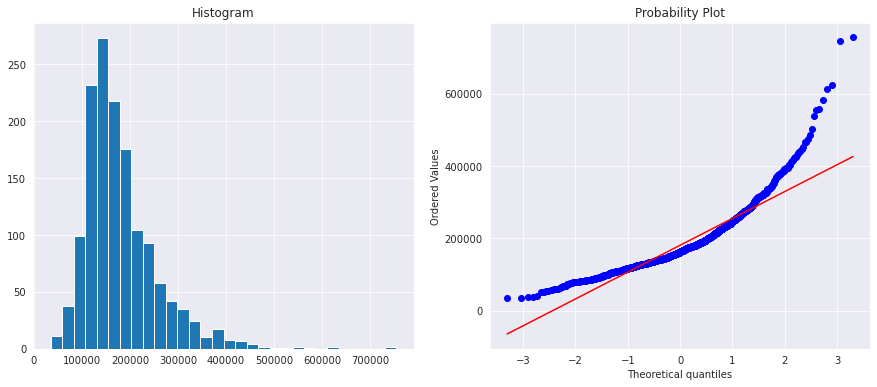

In [42]:
  plt.figure(figsize=(15,6))
  plt.subplot(1,2,1)
  plt.hist(train_data['SalePrice'],bins=30)
  plt.title('Histogram')

  plt.subplot(1,2,2)
  stat.probplot(train_data['SalePrice'],dist='norm',plot=pylab)
  plt.show()

In [43]:
train_data["SalePrice"],fitted_lambda= boxcox(train_data["SalePrice"],lmbda=None)

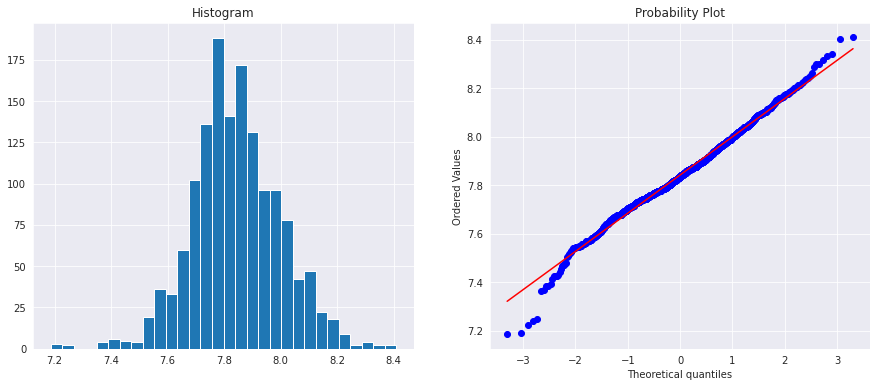

In [44]:
  plt.figure(figsize=(15,6))
  plt.subplot(1,2,1)
  plt.hist(train_data['SalePrice'],bins=30)
  plt.title('Histogram')

  plt.subplot(1,2,2)
  stat.probplot(train_data['SalePrice'],dist='norm',plot=pylab)
  plt.show()

### Outlier Treatment

In [45]:
for i in numerical_col:
  print(i)
  print(train_data[i].sort_values(ascending=False).head(10))
  print('='*40)

Id
1459    1460
1458    1459
1457    1458
1456    1457
1455    1456
1454    1455
1453    1454
1452    1453
1451    1452
1450    1451
Name: Id, dtype: int64
MSSubClass
861     190
1062    190
48      190
1266    190
520     190
335     190
535     190
969     190
1416    190
1030    190
Name: MSSubClass, dtype: int64
LotFrontage
1298    313.0
934     313.0
1127    182.0
197     174.0
231     174.0
1107    168.0
1182    160.0
1337    153.0
1211    152.0
313     150.0
Name: LotFrontage, dtype: float64
LotArea
313     215245
335     164660
249     159000
706     115149
451      70761
1298     63887
1396     57200
769      53504
457      53227
384      53107
Name: LotArea, dtype: int64
OverallQual
1298    10
1442    10
515     10
523     10
1169    10
825     10
1182    10
1373    10
583     10
591     10
Name: OverallQual, dtype: int64
OverallCond
185     9
508     9
1435    9
461     9
703     9
1327    9
991     9
980     9
191     9
241     9
Name: OverallCond, dtype: int64
YearBuilt
37

In [46]:
train_data.drop(train_data.index[[297,706,249,335,346,1298,1089,325,1146,1043]], inplace=True)

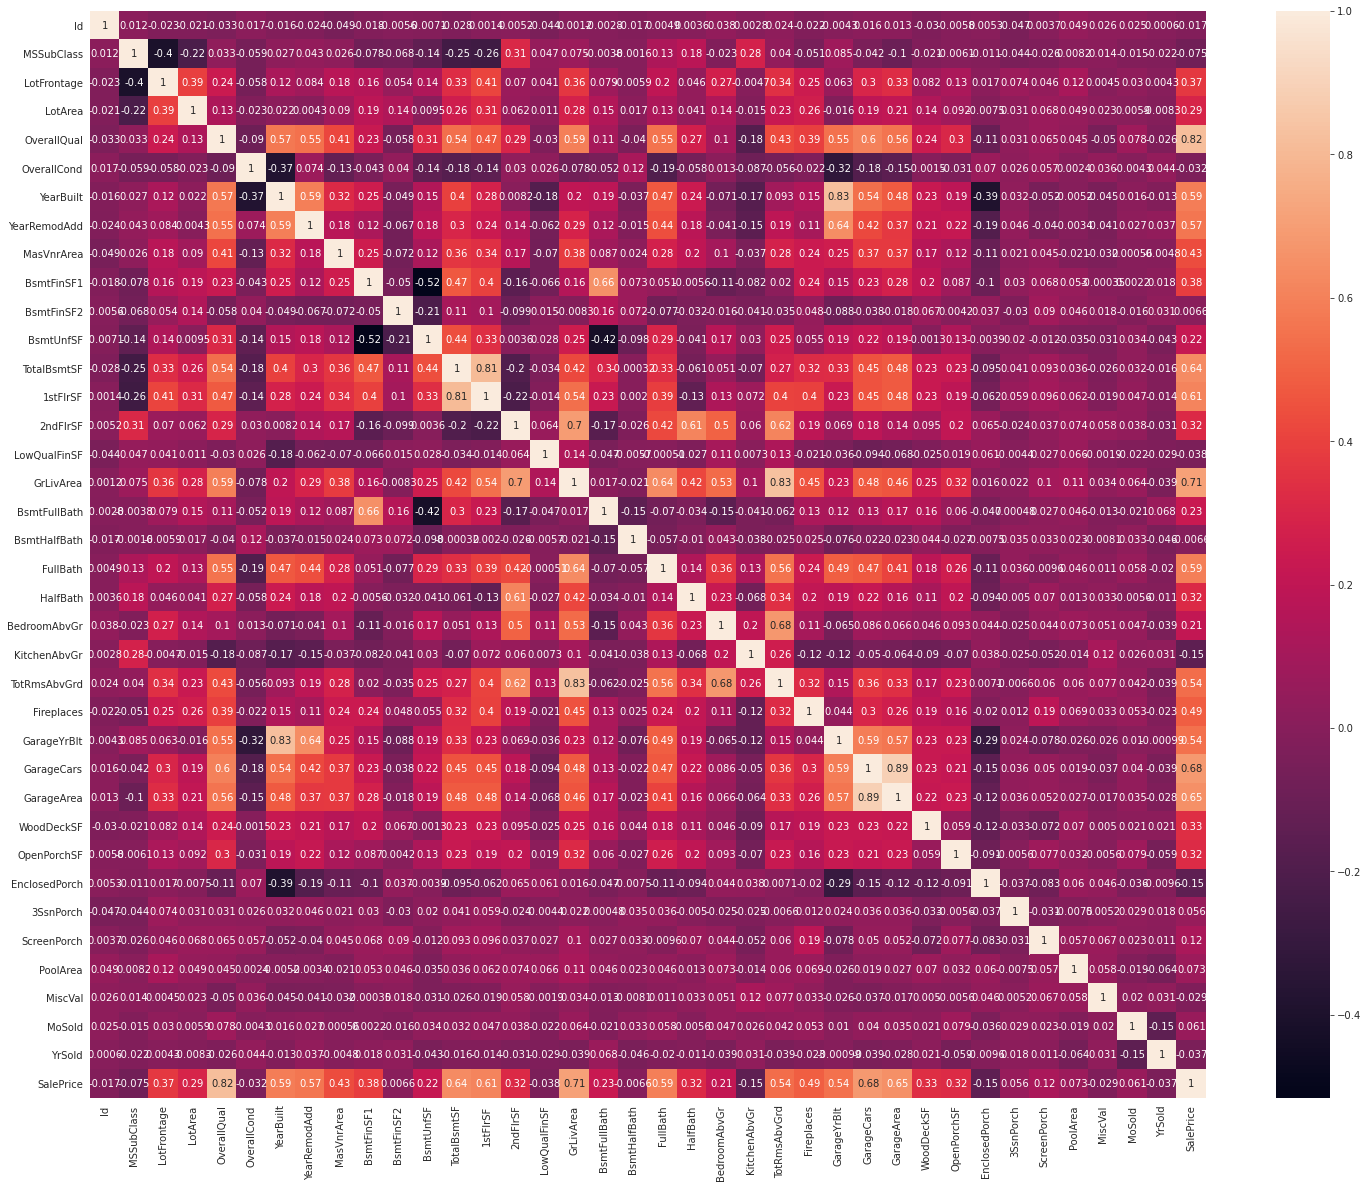

In [47]:
plt.figure(figsize=(25,20))
sns.heatmap(train_data[numerical_col].corr(),annot=True)
plt.show()

### Drop columns

In [48]:
# Append test & train dataset
df = pd.concat([train_data.iloc[:,:-1], test_data],sort = False)

# separating target column
y = train_data['SalePrice']

In [49]:
# drop columns where more than 80% records are missing

column_to_drop = ['Alley','PoolQC','Fence','MiscFeature']
df.drop(column_to_drop,axis = 1,inplace = True)

In [50]:
df = df.drop(['GarageYrBlt','YearBuilt','Id','GarageArea', 'TotRmsAbvGrd', '1stFlrSF'],axis=1)

In [51]:
df['MSSubClass'] = df['MSSubClass'].apply(str)
df['YearRemodAdd'] = df['YearRemodAdd'].astype(str)
df['YrSold'] = df['YrSold'].astype(str)

## Missing Value Treatment

In [52]:
column_name = ['FireplaceQu','MasVnrType','Electrical']
bsmt_garage = [i for i in df.columns if ('bsmt' in i.lower()) or ('garage' in i.lower())]
column_name.extend(bsmt_garage)

for i in column_name:
  if df[i].dtype == object:
    df[i] = df[i].fillna('Missing')
  elif df[i].dtype == np.float64:
    df[i] = df[i].fillna(0)

In [53]:
def update_by_overallqual(data,column):
  for i in data['OverallQual'].unique():
    data[data['OverallQual']==i] = data[data['OverallQual']==i].fillna({column:data[data['OverallQual']==i][column].median()})

In [54]:
update_by_overallqual(df,'LotFrontage')
update_by_overallqual(df,'MasVnrArea')

In [55]:
numerical_col = [i for i in df.columns if df[i].dtype != object]
catagorical_col = [i for i in df.columns if df[i].dtype == object]
print('train data contains',len(numerical_col), 'numerical columns and ',len(catagorical_col),'catagorical columns')

train data contains 28 numerical columns and  42 catagorical columns


### Separating test & train column

In [56]:
train, test = df.iloc[:1450,:] ,df.iloc[1450:,:]

In [57]:
# Summary of missing columns on test & train 
print('training_data : \n',missing_col_summary(train),'\n','='*75,'\n','test_data : \n',missing_col_summary(test))

training_data : 
 Empty DataFrame
Columns: [Total_missing, missing %, Total_non_missing, total_records]
Index: [] 
 test_data : 
              Total_missing  missing %  Total_non_missing  total_records
MSZoning                 4       0.27               1455           1459
Utilities                2       0.14               1457           1459
Exterior1st              1       0.07               1458           1459
Exterior2nd              1       0.07               1458           1459
KitchenQual              1       0.07               1458           1459
Functional               2       0.14               1457           1459
SaleType                 1       0.07               1458           1459


### Classify Categorical Variable by ML prediction

In [58]:
column_contains_missing =  [i for i in test.columns if test[i].isnull().sum()>0]

def encoding(x):
  encoder = LabelEncoder()
  return encoder.fit_transform(x)

def encoding_values(df):
  for i in df.columns:
    if df[i].dtype == object:
      df.loc[:,i] = encoding(df.loc[:,i])

train_X = train[[i for i in train.columns[:-1] if i not in column_contains_missing]]
encoding_values(train_X)

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [59]:
for i in column_contains_missing:
  print("========================={}=========================".format(i))

  print('Original Records','\n','*'*30)
  print(train[i].value_counts())
  test_X = test[test[i].isnull()][train_X.columns]
  encoding_values(test_X)
  train_y = encoding(train[i])
  print('LabelEncoded Records','\n','*'*30)
  print(pd.DataFrame(train_y)[0].value_counts())

  model = XGBClassifier(random_state=42)
  model.fit(train_X, train_y)
  print(model.score(train_X, train_y))
  print('Predicted Vale: ', model.predict(test_X))

=========================MSZoning=========================
Original Records 
 ******************************
RL         1144
RM          217
FV           63
RH           16
C (all)      10
Name: MSZoning, dtype: int64
LabelEncoded Records 
 ******************************
3    1144
4     217
1      63
2      16
0      10
Name: 0, dtype: int64
1.0
Predicted Vale:  [3 3 3 3]
=========================Utilities=========================
Original Records 
 ******************************
AllPub    1449
NoSeWa       1
Name: Utilities, dtype: int64
LabelEncoded Records 
 ******************************
0    1449
1       1
Name: 0, dtype: int64
0.9993103448275862
Predicted Vale:  [0 0]
=========================Exterior1st=========================
Original Records 
 ******************************
VinylSd    514
HdBoard    221
MetalSd    217
Wd Sdng    204
Plywood    106
CemntBd     61
BrkFace     50
WdShing     26
Stucco      24
AsbShng     20
Stone        2
BrkComm      2
ImStucc      1
CBlock    

In [60]:
# test data has been classified based on XGBClassifier
test = test.fillna({'MSZoning' : 'RL',
                    'Utilities':'AllPub',
                    'Exterior1st' : 'MetalSd', 
                    'Exterior2nd':'MetalSd',
                    'KitchenQual':'Fa',
                    'Functional':'Typ',
                    'SaleType':'WD'})

In [61]:
test.columns == train.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True])

In [62]:
for i in train.columns:
  if test[i].dtype != train[i].dtype:
    print(i)

In [63]:
# Applying LabelEncoder

encoding_values(train)
encoding_values(test)

In [64]:
train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,Functional,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageCars,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,9,3,65.0,8450,1,3,3,0,4,0,5,2,2,0,5,7,5,53,1,0,12,13,1,196.0,2,4,2,2,4,4,2,706.0,6,0.0,150.0,856.0,1,0,1,5,854,0,1710,1.0,0.0,2,1,3,1,2,6,0,3,1,2,2.0,5,5,2,0,61,0,0,0,0,0,2,2,8,4
1,4,3,80.0,9600,1,3,3,0,2,0,24,1,2,0,2,6,8,26,1,0,8,8,3,0.0,3,4,1,2,4,1,0,978.0,6,0.0,284.0,1262.0,1,0,1,5,0,0,1262,0.0,1.0,2,0,3,1,3,6,1,5,1,2,2.0,5,5,2,298,0,0,0,0,0,0,5,1,8,4
2,9,3,68.0,11250,1,0,3,0,4,0,5,2,2,0,5,7,5,52,1,0,12,13,1,162.0,2,4,2,2,4,3,2,486.0,6,0.0,434.0,920.0,1,0,1,5,866,0,1786,1.0,0.0,2,1,3,1,2,6,1,5,1,2,2.0,5,5,2,0,42,0,0,0,0,0,9,2,8,4
3,10,3,60.0,9550,1,0,3,0,0,0,6,2,2,0,5,7,5,20,1,0,13,15,3,0.0,3,4,0,4,1,4,0,216.0,6,0.0,540.0,756.0,1,2,1,5,756,0,1717,1.0,0.0,1,0,3,1,2,6,1,2,5,3,3.0,5,5,2,0,35,272,0,0,0,0,2,0,8,0
4,9,3,84.0,14260,1,0,3,0,2,0,15,2,2,0,5,8,5,50,1,0,12,13,1,350.0,2,4,2,2,4,0,2,655.0,6,0.0,490.0,1145.0,1,0,1,5,1053,0,2198,1.0,0.0,2,1,4,1,2,6,1,5,1,2,3.0,5,5,2,192,84,0,0,0,0,0,12,2,8,4


In [65]:
test.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,Functional,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageCars,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,5,2,80.0,11622,1,3,3,0,4,0,12,1,2,0,2,5,6,11,1,0,10,12,3,0.0,3,4,1,4,4,4,5,468.0,3,144.0,270.0,882.0,0,4,1,3,0,0,896,0.0,0.0,1,0,2,1,3,6,0,3,1,3,1.0,4,5,2,140,0,0,0,120,0,0,6,4,8,4
1,5,3,81.0,14267,1,0,3,0,0,0,12,2,2,0,2,6,6,8,3,0,11,13,1,108.0,3,4,1,4,4,4,0,923.0,6,0.0,406.0,1329.0,0,4,1,3,0,0,1329,0.0,0.0,1,1,3,1,2,6,0,3,1,3,1.0,4,5,2,393,36,0,0,0,0,12500,6,4,8,4
2,10,3,74.0,13830,1,0,3,0,4,0,8,2,2,0,4,5,5,48,1,0,10,12,3,0.0,3,4,2,2,4,4,2,791.0,6,0.0,137.0,928.0,0,2,1,3,701,0,1629,0.0,0.0,2,1,3,1,3,6,1,5,1,0,2.0,4,5,2,212,34,0,0,0,0,0,3,4,8,4
3,10,3,78.0,9978,1,0,3,0,4,0,8,2,2,0,4,6,6,48,1,0,10,12,1,20.0,3,4,2,4,4,4,2,602.0,6,0.0,324.0,926.0,0,0,1,3,678,0,1604,0.0,0.0,2,1,3,1,2,6,1,2,1,0,2.0,4,5,2,360,36,0,0,0,0,0,6,4,8,4
4,0,3,43.0,5005,1,0,1,0,4,0,22,2,2,4,2,8,5,42,1,0,6,6,3,0.0,2,4,2,2,4,4,0,263.0,6,0.0,1017.0,1280.0,0,0,1,3,0,0,1280,0.0,0.0,2,0,2,1,2,6,0,3,1,2,2.0,4,5,2,0,82,0,0,144,0,0,1,4,8,4


In [66]:
X = train

# SalePrice is y value

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Scaling and normalization

In [67]:
scaler = RobustScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [68]:
# ML models
model_classifiers = {'K-Nearest_Neighbors': KNeighborsRegressor(),
                     'LinearRegression'   : LinearRegression(),
                     'Gradient_Boosting'  : GradientBoostingRegressor(),
                     'AdaBoost Regressor' : AdaBoostRegressor(),
                     'LassoLarsIC'        : LassoLarsIC(),
                     'Random_Forest'      : RandomForestRegressor(),
                     'BayesianRidge'      : BayesianRidge(),
                     'Lasso'              : Lasso(),
                     'ElasticNet'         : ElasticNet(),
                     'ElasticNetCV'       : ElasticNetCV(),
                     'XGBRegressor'       : XGBRegressor(objective ='reg:linear'
                                            , verbosity = 0, random_state=42),
                     'Support Vector Machine':SVR(),
                     'ExtraTreesRegressor':ExtraTreesRegressor()
                     }

In [69]:
# Function to evaluate models
def model_evaluate(x_train_df,y_train_df,x_test_df,y_test_df,model_list):

  train_score = []
  test_score = []
  mse = []
  msle = []
  mae =[]
  for i in model_list.values():
    i.fit(x_train_df,y_train_df)
    train_score.append(i.score(x_train_df,y_train_df))
    test_score.append(i.score(x_test_df,y_test_df))
    mse.append(mean_squared_error(y_test_df,i.predict(x_test_df)))
    msle.append(mean_squared_log_error(y_test_df,i.predict(x_test_df)))
    mae.append(mean_absolute_error(y_test_df,i.predict(x_test_df)))


  return pd.DataFrame({'Model Name'    : [ i for i in model_list.keys()],
                       'Training Score': train_score,
                       'Test Score'    : test_score,
                       'MSE'           : mse,
                       'RMSE'          : np.sqrt(mse),
                       'MSLE'          : msle,
                       'RMSLE'         : np.sqrt(msle),
                       'MAE'           : mae
                       }
                      )

In [70]:
model_evaluate(X_train,y_train,X_test,y_test,model_classifiers)

,Model Name,Training Score,Test Score,MSE,RMSE,MSLE,RMSLE,MAE
0,K-Nearest_Neighbors,0.715089,0.556602,0.011321,0.106401,0.000147,0.012129,0.070698
1,LinearRegression,0.901415,0.882301,0.003005,0.054819,0.000039,0.006284,0.037854
2,Gradient_Boosting,0.960182,0.889967,0.002809,0.053004,0.000037,0.006078,0.035225
3,AdaBoost Regressor,0.849363,0.817358,0.004663,0.068289,0.000061,0.007819,0.049602
4,LassoLarsIC,0.863950,0.871643,0.003277,0.057248,0.000043,0.006571,0.039832
5,Random_Forest,0.980030,0.872043,0.003267,0.057158,0.000043,0.006564,0.037955
6,BayesianRidge,0.899900,0.889069,0.002832,0.053220,0.000037,0.006099,0.037154
7,Lasso,0.017860,0.007048,0.025353,0.159225,0.000327,0.018077,0.122245
8,ElasticNet,0.034766,0.018497,0.025060,0.158305,0.000323,0.017974,0.121310
9,ElasticNetCV,0.889594,0.892634,0.002741,0.052358,0.000036,0.006014,0.036022


In [71]:
model_lst = []
cross_val = []
for i in model_classifiers.keys():
  model_lst.append(i)
  cv_scores = cross_val_score(model_classifiers[i],X,y, cv=5)
  cross_val.append(np.mean(cv_scores))
pd.DataFrame({'Model Name': model_lst, 'cross_val_score':cross_val})

,Model Name,cross_val_score
0,K-Nearest_Neighbors,0.648114
1,LinearRegression,0.879975
2,Gradient_Boosting,0.888481
3,AdaBoost Regressor,0.799868
4,LassoLarsIC,0.873709
5,Random_Forest,0.869383
6,BayesianRidge,0.880881
7,Lasso,0.667204
8,ElasticNet,0.735786
9,ElasticNetCV,0.749791


# Apply Models

In [72]:
# model to evaluate results
def evaluate(actual_value,predictions):
  print("Mean Squared Error:"+str(mean_squared_error(actual_value,predictions)))
  print("Root Mean Squared Error:"+str(np.sqrt(mean_squared_error(actual_value,predictions))))
  print("Mean Squared Log Error:"+str(mean_squared_log_error(actual_value,predictions)))
  print("Root Mean Squared Log Error:"+str(np.sqrt(mean_squared_log_error(actual_value,predictions))))
  print("Mean Absolute Error:"+str(mean_absolute_error(actual_value,predictions)))

In [73]:
model = GradientBoostingRegressor()
model.fit(X_train,y_train)

GradientBoostingRegressor()

In [74]:
evaluate(y_test,model.predict(X_test))

Mean Squared Error:0.002842660229029783
Root Mean Squared Error:0.053316603689936806
Mean Squared Log Error:3.741073396236475e-05
Root Mean Squared Log Error:0.0061164314728740935
Mean Absolute Error:0.035318811669616486


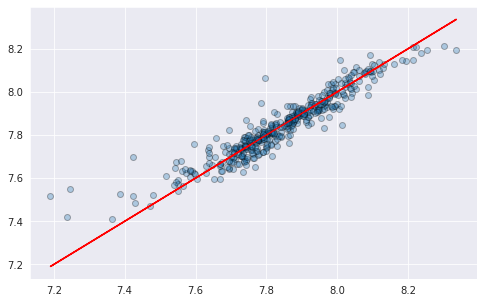

In [75]:
plt.figure(figsize=(8,5))
plt.scatter(y_test,model.predict(X_test),ec='black',alpha = 0.3)
plt.plot(y_test,y_test, 'r')
plt.show()

# Applying model in train data

In [76]:
scaler = RobustScaler()

X_train = scaler.fit_transform(train)
X_test = scaler.transform(test)
y_train = y

In [77]:
model = ElasticNetCV()
#model = GradientBoostingRegressor()
model.fit(X_train,y_train)

ElasticNetCV()

In [78]:
predicted_value = pd.DataFrame(inv_boxcox(model.predict(X_test),fitted_lambda),columns=['SalePrice'])

In [79]:
pd.concat([test_data,predicted_value],axis=1)[['Id','SalePrice']].to_csv('submission.csv',index=False)